# Content

In this notebook we run our algorithm to distinguish the classes of the SP data. Each point represents two classes and and one day. The pipeline goes as follows

* We first load the data from the `SP_Classes_2_per_day` folder
* We then generate the embeddings
* For visualization porpuses we plot the embeddings in 2 dimensions using *UMAP* algorithm

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
import matplotlib.cm as cm
from collections import Counter
from matplotlib.colors import Normalize
import umap

import sys
sys.path += ['dir_to_package/Package']

from MatrixDistance import *

import warnings
warnings.filterwarnings("ignore")

2023-10-19 15:09:19.968722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-19 15:09:19.968744: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# # load the data
# ROOT = 'Data/SP_Classes_2_per_day/'
# all_files = listdir(ROOT)

# n = len(all_files)
# gt = [x.split('-')[0] for x in all_files]

# DFT = []

# for file in all_files:
#     DFT.append(pd.read_csv(ROOT + file))
    
# school = np.array([x.split('-')[0] for x in all_files])
# classes = np.array([x.split('-')[1] for x in all_files])
    
# # generate the embeddings
# λlist = []

# for i in range(n):
#     # print progress
#     print(str(i+1) + '/' + str(n), end = '\r')
    
#     N = len(np.unique(DFT[i][['i', 'j']].values))
#     X = GraphDynamicEmbedding(DFT[i], dim = 32, n = N, n_epochs = 30, η = 1)
#     λlist.append(np.linalg.eigvalsh(X.T@X))
    
# np.savetxt('Data/Embeddings/2PerClass.dat', np.array(λlist))

In [3]:
# # SP class
# Xclass = np.loadtxt('Data/Embeddings/2PerClass.dat')
# Xclass_embedded = TSNE(n_components = 2, perplexity = 50).fit_transform(Xclass)
# all_files = listdir('Data/SP_Classes_2_per_day/')
# gt = [x.split('-')[0] for x in all_files]

# # synthetic data
# Xsynth = np.loadtxt('Data/Embeddings/Synthetic/embs.txt')
# n_graphs = 250
# Xsynth_embedded = TSNE(n_components = 2, perplexity = 50).fit_transform(Xsynth)
# gt_synth = np.concatenate([[i for x in range(n_graphs)] for i in range(4)])
# size = np.loadtxt('Data/Embeddings/Synthetic/size.txt')

In [11]:
Xclass = np.loadtxt('Data/Embeddings/2PerClass.dat')
Xclass_embedded = umap.UMAP(n_neighbors = 500, min_dist = 1).fit_transform(Xclass)

all_files = listdir('Data/SP_Classes_2_per_day/')
gt = [x.split('-')[0] for x in all_files]

# synthetic data
Xsynth = np.loadtxt('Data/Embeddings/Synthetic/embs.txt')
n_graphs = 250
Xsynth_embedded = umap.UMAP(n_neighbors = 500, min_dist = 1).fit_transform(Xsynth)
gt_synth = np.concatenate([[i for x in range(n_graphs)] for i in range(4)])
size = np.loadtxt('Data/Embeddings/Synthetic/size.txt')

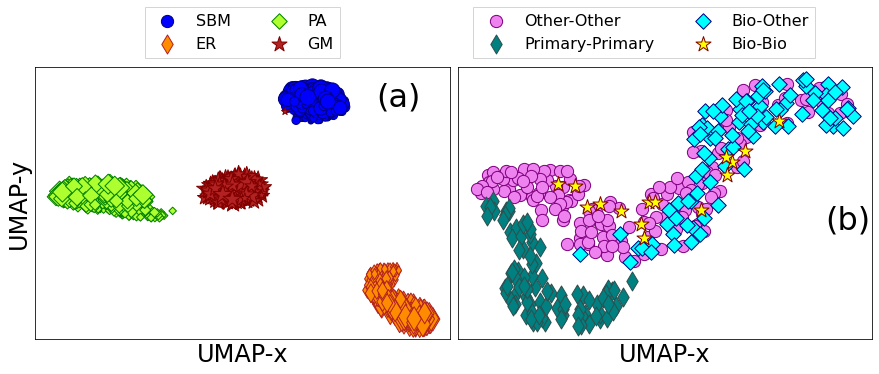

In [12]:
fig, ax = plt.subplots(1,2, figsize = (15, 5), gridspec_kw={'wspace' : 0.02})
   
norm = Normalize(vmin = 0, vmax = 6)
cmap = cm.Oranges

m = cm.ScalarMappable(norm=norm, cmap=cmap)


labels = ['SBM', 'ER', 'PA', 'GM']

colors = ['blue', 'darkorange', 'greenyellow', 'firebrick']
colors2 = ['violet', 'teal', 'cyan', 'yellow']

edgecolors = ['navy', 'firebrick', 'green', 'maroon']
edgecolors2 = ['purple', 'darkslategrey', 'navy', 'maroon',]
markers = ['o', 'd', 'D', '*', 's']
sizes = [150, 180, 120, 250, 200]

for i in [0, 1, 2, 3]:

    ax[0].scatter(Xsynth_embedded[:,0][gt_synth == i], Xsynth_embedded[:,1][gt_synth == i], marker = markers[i], 
            color = colors[i], edgecolor = edgecolors[i], label = labels[i], 
                  s = sizes[i]/1000*np.array(size)[gt_synth == i])
    
ax[0].legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.25), fontsize = 16,
          ncol = 2, fancybox = False, shadow = False)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlim(1.1*np.min(Xsynth_embedded[:,0]), 1.1*np.max(Xsynth_embedded[:,0]))
ax[0].set_ylim(1.3*np.min(Xsynth_embedded[:,1]), 1.1*np.max(Xsynth_embedded[:,1]))
ax[0].set_xlabel('UMAP-x', fontsize = 24)
ax[0].set_ylabel('UMAP-y', fontsize = 24)

school = np.array([x.split('-')[0] for x in all_files])
classes = np.array([x.split('-')[1] for x in all_files])
classes1 = [x.split('_')[0] for x in classes]
classes2 = [x.split('_')[1] for x in classes]

ClassMapper = {'1A': 0, '1B': 0, '2A': 0, '2B': 0,
'2BIO1': 1, '2BIO2': 1, '2BIO3': 1, '3A': 0,
'3B': 0, '4A': 0, '4B': 0, '5A': 0,
'5B': 0, 'MP': 2, 'MP*1': 2, 'MP*2': 2, 
'PC': 2, 'PC*': 2, 'PSI*': 2}

cl = [tuple([ClassMapper[x], ClassMapper[y]]) for x, y in zip(classes1, classes2)]

all_classes = list(Counter(cl).keys())

MapperNames = {0: 'Primary', 1: 'Bio', 2: 'Other'}

school = np.array([x.split('-')[0] for x in all_files])
schools = np.unique(school)

for i, s in enumerate(all_classes):
    idx = np.array([x == s for x in cl])
    ax[1].scatter(Xclass_embedded[:,0][idx], Xclass_embedded[:,1][idx], marker = markers[i], 
                      edgecolor = edgecolors2[i], s = sizes[i], color = colors2[i], 
                  label = MapperNames[s[0]] + '-' + MapperNames[s[1]])

    
ax[1].legend(loc = 'upper center', bbox_to_anchor=(0.45, 1.25), fontsize = 16,
          ncol = 2, fancybox = False, shadow = False)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP-x', fontsize = 24)

ax[0].text(8, 34, '(a)', fontsize = 32)
ax[1].text(17, 11, '(b)', fontsize = 32)
    
    
# plt.savefig('../Paper/Figures/recognize_graphs.pdf', dpi = 400, bbox_inches = 'tight')
plt.show();